In [14]:
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
import pandas as pd
from scipy import stats
from math import exp, expm1

## 1. Load the dataset & label 2 classes

In [28]:
################################################# 1.Loading the dataset
df_raw = pd.read_csv("https://raw.githubusercontent.com/J-tin/CarryOn/Exuberance-in-Financial-Markets-Evidence-from-Machine-Learning-Algorithms/Data_SVM.csv")

# Delete the second row of the dataframe 
df = df_raw.iloc[1:]

# Rename the first row of the dataframe
df_new = df.rename(columns={'MSCI World ': 'Date', 'NDDUWI': 'monthly_price', 'MSCI WORLD U$ - PRICE/BOOK RATIO':'P/B', 'MSCI WORLD U$ - DIVIDEND YIELD':'div Y'})

# Inspect the data
# print(df_new.head(6))
# print(df_new.info())

####################################################################### Calculate 1-month, 12-month, 60-month returns
lags = [1, 12, 60]

# Convert pandas.Series from object to float using pd.to_numeric(s, errors='coerce')
for lag in lags:
    df_new[f'return_{lag}m']=(pd.to_numeric(df_new['monthly_price'], errors='coerce').
                            pct_change(lag)
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
print(df_new.head(15))

# Reference link: https://books.google.de/books?id=tx2CDwAAQBAJ&pg=PA101&lpg=PA101&dq=compute+returns+for+various+holding+periods+using+python&source=bl&ots=uj8KrNq8ls&sig=ACfU3U0xMVTXnEjGPdLu8oqIRvXzjd3DaQ&hl=zh-CN&sa=X&ved=2ahUKEwijv5Cpzs7pAhWK-6QKHfDBAYwQ6AEwCnoECAkQAQ#v=onepage&q=compute%20returns%20for%20various%20holding%20periods%20using%20python&f=false

# df_new.info()

################################################ Descriptive statistics (shape of a dataset’s distribution) excluding NaN values.
stats = df_new.describe()
print(stats)

# Accessing 25% quantile value using loc attribute with a dataframe
pi = stats.loc['25%', 'return_60m']
# print(pi)


################################################################ Create a new dataframe 'df_60m' from the dataframe 'df_new'
df_60m = pd.DataFrame(df_new, columns = ['P/B', 'div Y', 'return_60m'])
# Slice the series until the 484th row, since the number of Return_60m is 484.
df_60m = df_60m.loc[0:484,:]

# Create a coulmn vector "return_60m" from the dataframe 'df_new' and Drop NaN values
return_60m = df_new['return_60m'].dropna()


# Align the return_60m values with corresponding features 
return_60m_loc = df_60m.columns.get_loc("return_60m")

for i in range(len(df_60m['return_60m'])):
    df_60m.iat[i,return_60m_loc] = return_60m[i+61]
    df_60m.loc[i+1,'div Y'] = float(df_60m.loc[i+1,'div Y'])/100
# print(df_60m.head())


############################################################# Add 'label' column in the datafram 'df_60m'
label = []
return_60m_loc = df_60m.columns.get_loc("return_60m")

for i in range(len(df_60m['return_60m'])):
    return_60m = df_60m.iat[i, return_60m_loc]

    if return_60m >= pi:
        label.append(0)
    else:
        label.append(1)

# Add a new column 'label' to the dataframe
df_60m['label'] = label

# Convert pandas.Serioes from dtype object to float, since ploting a scatter graph needs numeric values.
df_60m = df_60m.apply(pd.to_numeric, errors='coerce')
df_60m.head()

          Date monthly_price   P/B div Y  return_1m  return_12m  return_60m
1   1974/12/31         88.76  1.08   5.4        NaN         NaN         NaN
2    1975/1/31         101.7  1.22   4.7   0.145786         NaN         NaN
3    1975/2/28        110.68   1.3   4.4   0.088299         NaN         NaN
4    1975/3/31        111.49  1.29   4.4   0.007318         NaN         NaN
5    1975/4/30        116.11  1.33   4.2   0.041439         NaN         NaN
6    1975/5/30        118.86  1.35   4.1   0.023684         NaN         NaN
7    1975/6/30        120.36  1.37     4   0.012620         NaN         NaN
8    1975/7/31        113.71  1.31   4.2  -0.055251         NaN         NaN
9    1975/8/29        111.95  1.29   4.3  -0.015478         NaN         NaN
10   1975/9/30        107.25  1.24   4.4  -0.041983         NaN         NaN
11  1975/10/31        114.64  1.31   4.2   0.068904         NaN         NaN
12  1975/11/28        117.77  1.35     4   0.027303         NaN         NaN
13  1975/12/

,P/B,div Y,return_60m,label
1,1.08,0.054,0.011280,0
2,1.22,0.047,0.009971,0
3,1.30,0.044,0.008553,0
4,1.29,0.044,0.006517,0
5,1.33,0.042,0.006897,0


## Visualize the data -- Scatter plot

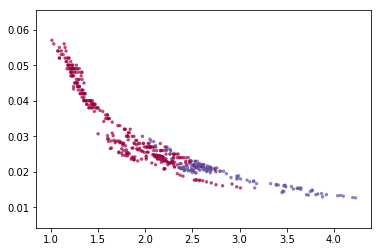

In [29]:
P_B = df_60m['P/B']
div_Y = df_60m['div Y']
label = df_60m['label']
plt.scatter(P_B,div_Y, c=label, cmap=plt.cm.Spectral,alpha=0.6, s=6)

## 2. Preprocess the data -- Scaling the data

In [34]:
# Create a numpy-array (matrix) X that contains 2 features (x1, x2)
# Create a numpy-array (vector) Y that contains your labels (1,-1).
# Merge two numpy columns in onw array
X_data = df_60m.iloc[:484,0:2].values   # (484, 2) 
Y_data= label.iloc[:484].values       # Array (484,)

# Standardlization (Reference: https://www.cnblogs.com/cnkai/p/7755078.html)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_data)
X = scaler.transform(X_data)
# X =X.T

# Create a numpy-array (vector) Y that contains your labels (1,0).
Y = label.iloc[:484].values       # Array (484,)
# print(X)

m = X.shape[0]       # training set size
shape_X = X.shape
shape_Y = Y.shape    # (484,1)

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (484, 2)
The shape of Y is: (484,)
I have m = 484 training examples!


# 3. Model 1: Simple logistic regression model

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model         # 使用sklearn包的LogisticRegression做二分类
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

## 3.1 Define & Train the model

In [48]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()    # Solver lbfgs supports only 'l2' or 'none' penalties

clf.fit(X, Y)

LogisticRegressionCV()

## 3.2 Visualization the logistic regression line: Plot the decision boundary

Text(0.5, 1.0, 'Logistic Regression, Decision Boundary')

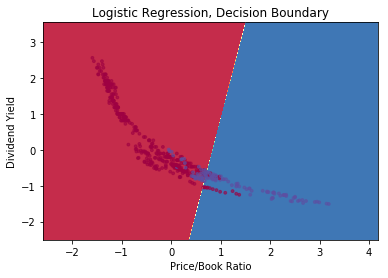

In [76]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)
plt.title("Logistic Regression, Decision Boundary")   

## 3.3 Evaluate the model, obtain accuracy, prediction, F1, AUC
参考内容： 3.3. Metrics and scoring: quantifying the quality of predictions
3.3.1.4. Using multiple metric evaluation¶

参考链接：https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from keras.callbacks import EarlyStopping, ModelCheckpoint
%load_ext tensorboard
import statistics

# As a dict mapping the scorer name to the scoring function::
scoring = {'accuracy': make_scorer(accuracy_score),
           'prec': 'precision',
           'F1':'f1',
           'AUC': 'roc_auc'}

cv_results = cross_validate(clf.fit(X, Y), X, Y, cv=10, scoring=scoring)

cv_results


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.1815176 , 0.17474556, 0.21494293, 0.1949904 , 0.17852116,
        0.20046473, 0.17652917, 0.22938538, 0.19148803, 0.17803478]),
 'score_time': array([0.00598502, 0.00399089, 0.0029912 , 0.00398779, 0.00299239,
        0.00398803, 0.00598335, 0.00299239, 0.00498652, 0.00498652]),
 'test_accuracy': array([0.95918367, 1.        , 1.        , 1.        , 0.77083333,
        0.75      , 0.58333333, 0.70833333, 0.9375    , 0.75      ]),
 'test_prec': array([1.        , 1.        , 1.        , 1.        , 0.52380952,
        0.        , 0.25      , 0.45833333, 1.        , 0.        ]),
 'test_F1': array([0.90909091, 1.        , 1.        , 1.        , 0.66666667,
        0.        , 0.28571429, 0.61111111, 0.85714286, 0.        ]),
 'test_AUC': array([1.        , 1.        , 1.        , 1.        , 0.9537037 ,
        0.98842593, 0.68287037, 0.69907407, 1.        , 0.83333333])}

In [39]:
test_accuracy = statistics.mean(cv_results['test_accuracy'])
test_pre = statistics.mean(cv_results['test_prec'])
test_f1 = statistics.mean(cv_results['test_F1'])
test_auc = statistics.mean(cv_results['test_AUC'])

print("Average Accuracy rate: %.2f%%" % (test_accuracy*100))
print("Average Prediction rate: %.2f%%" %(test_pre*100))
print("Average F1 score: %.2f%%" %(test_pre*100))
print("Average AUC: %.2f%%" %(test_pre*100))

Average Accuracy rate: 84.59%
Average Prediction rate: 62.32%
Average F1 score: 62.32%
Average AUC: 62.32%


## 3.4 Interpretation: 
The dataset is pretty linearly separable, so logistic regression does perform well. 

We expect a neural network will do better. 

####  测评估计量补充： F1 score, also known as balanced F-score or F-measure

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
F1 = 2 * (precision * recall) / (precision + recall)

参考链接： https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

# 4. Model 2: DNN with 2 hidden layers (16,16)

## 4.1 Split the dataset into Training Set & Test Set

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# 代码参考：https://scikit-learn.org/stable/auto_examples/classification/plot_cl

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy 
from keras.models import Sequential
from keras.layers.core import Dense
from keras.callbacks import Callback

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy 
from keras import backend as K

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []

for train, test in kfold.split(X, Y):
    # Create a three-layer network model
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_shape=(2,)))
    model.add(Dense(16, activation ='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics =['accuracy'])

    # Fit the model
    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    
    # Print the validation accuracy each time
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    

print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 89.80%
accuracy: 85.71%
accuracy: 87.76%
accuracy: 87.76%
accuracy: 89.58%
accuracy: 97.92%
accuracy: 83.33%
accuracy: 91.67%
accuracy: 87.50%
accuracy: 87.50%
88.85% (+/- 3.71%)


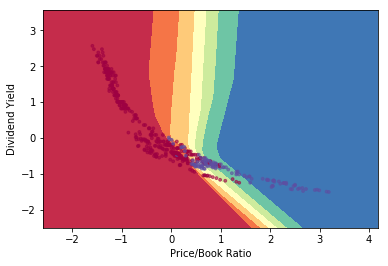

In [74]:
plot_decision_boundary(lambda x: model.predict(x), X.T, Y)

# 5. Model 3: DNN with 2-hidden layers (12,8) 

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

## 5.1 : Define the classifier

In [45]:
h = .02  # step size in the mesh
alphas = np.logspace(-1, 0, 5)   # Specify 5 alphas values
names = ['alpha ' + str(i) for i in alphas]
classifiers = []

# Define a 2-hidden-layer NN model based on varying regularization (alpha) in MLPClassifier
for i in alphas:
    classifiers.append(make_pipeline(        #功能函数 make_pipeline 是构建管道的缩写; 它接收多个评估器并返回一个管道，自动填充评估器名
                       StandardScaler(),
                       MLPClassifier(solver='lbfgs',        #‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
                                     alpha=i,               # L2 penalty (regularization term) parameter   
                                     activation='logistic', # Activation function for the hidden layer. 
                                                            # 'logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
                                     random_state=1,        # Determines random number generation for weights and bias initialization, train-test split if early stopping is used
                                     max_iter=2000,         # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
                                     early_stopping=True,   # Whether to use early stopping to terminate training when validation score is not improving.
                                                             # True: it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.
                                     hidden_layer_sizes=[12, 8])))  # We build 2 hidden layers. 12 neurons in the 1st layer; 8 in the 2nd one.



## 5.2 Prepare & Split the dataset

In [57]:
datasets = [(X, Y)]

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state = 42)

## 5.3 Plot the results

Test accuracy: 91.75%
Test accuracy: 91.75%
Test accuracy: 90.72%
Test accuracy: 89.69%
Test accuracy: 87.63%


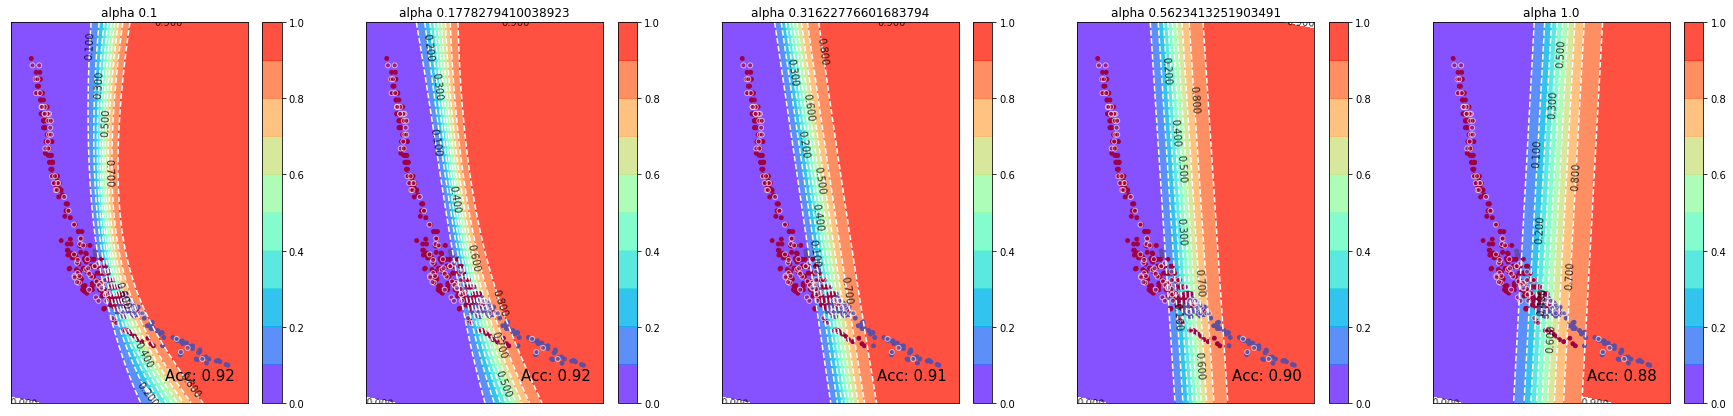

In [60]:
# Create a new figure with 30-inch width, 7-inch height
figure = plt.figure(figsize=(30, 7))  

# 设置横纵左边的长度及分段，根据数据长度而定
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# meshgrid函数就是用两个坐标轴上的点在平面上画网格(当然这里传入的参数是两个的时候)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),    # h = .02  step size in the mesh 网格中的步长
                         np.arange(y_min, y_max, h))


i = 1
# Iterate over classifiers
for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    ax = plt.subplot(1, 6, i)               # Add a subplot to the current figure 
    clf.fit(X_train, y_train)               # Train the model with automatically 10-fold cross validation which has been specidies in Classifiers
    score = clf.score(X_test, y_test)       # Evaluate the model by calculating the test accuracy
    
    print("Test accuracy: %.2f%%" % (score*100))
    

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predict_proba 是（软）分类器的一种方法，用于输出实例在每个类中的概率。

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cm = plt.cm.rainbow                # 设置彩色色谱
    contour = ax.contourf(xx, yy, Z, 10, cmap=cm, alpha=.8)    # contourf(X,Y,Z) 指定 Z 中各值的 x 和 y 坐标，10 means 10 regions
    ax.contour(contour, linestyles = 'dashed', colors='white') # Add line contours on the graph
    plt.clabel(contour,inline=True,fontsize=10,colors='k')    # Add labels to line contours in our ContourSet object
    figure.colorbar(contour, ax=ax)
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=15)
    
    # Plot the testing points with whilte edgecolors
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, alpha=0.6, edgecolors='white', s=25)

    # Set the limits
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('Acc: %.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    i += 1

figure.subplots_adjust(left=.02, right=.98)

# Display the plot
plt.show()

## 5.4 Evaluate the model

In [64]:
h = .02  # step size in the mesh
alphas = [0.3, 1.3]   # Specify 5 alphas values
names = ['alpha ' + str(i) for i in alphas]
classifiers = []

In [65]:
for i in alphas:
    classifiers.append(make_pipeline(        #功能函数 make_pipeline 是构建管道的缩写; 它接收多个评估器并返回一个管道，自动填充评估器名
                       StandardScaler(),
                       MLPClassifier(solver='lbfgs',        #‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
                                     alpha=i,               # L2 penalty (regularization term) parameter   
                                     activation='logistic', # Activation function for the hidden layer. 
                                                            # 'logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
                                     random_state=1,        # Determines random number generation for weights and bias initialization, train-test split if early stopping is used
                                     max_iter=2000,         # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
                                     early_stopping=True,   # Whether to use early stopping to terminate training when validation score is not improving.
                                                             # True: it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.
                                     hidden_layer_sizes=[12, 8]))) 

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics



i = 1
# iterate over classifiers
for name, clf in zip(names, classifiers):   # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    #这个跑的是原始的pipeline里的5个
    
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('Test accurancy:'+ str(score))
    
    #这个跑的是cv=5之后的准确度，按平均值来算有降低，但5个pipeline之间的排序是一样的
    scores = cross_val_score(clf, X, Y, cv=5, scoring='accuracy')
    score_acc = scores
    print('acc:'+ str(score_acc))
    print("acc average: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    scores = cross_val_score(clf, X, Y, cv=5, scoring='precision')
    score_PR = scores
    print('PR:'+ str(score_PR))
    print("PR average: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    scores = cross_val_score(clf, X, Y, cv=5, scoring='f1')
    score_f1 = scores
    print('F1:'+ str(score_f1))
    print("F1 average: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

Test accurancy:0.9175257731958762
acc:[1.         1.         0.6185567  0.67010309 0.85416667]
acc average: 0.83 (+/- 0.32)
PR:[1.         1.         0.32432432 0.43636364 1.        ]
PR average: 0.75 (+/- 0.61)
F1:[1.         1.         0.39344262 0.6        0.58823529]
F1 average: 0.72 (+/- 0.49)
Test accurancy:0.9175257731958762
acc:[1.         1.         0.6185567  0.65979381 0.875     ]
acc average: 0.83 (+/- 0.33)
PR:[1.         1.         0.32432432 0.42857143 1.        ]
PR average: 0.75 (+/- 0.61)
F1:[1.         1.         0.39344262 0.59259259 0.66666667]
F1 average: 0.73 (+/- 0.47)
Test accurancy:0.9072164948453608
acc:[0.97938144 1.         0.63917526 0.67010309 0.875     ]
acc average: 0.83 (+/- 0.30)
PR:[1.         1.         0.34285714 0.43636364 1.        ]
PR average: 0.76 (+/- 0.60)
F1:[0.95652174 1.         0.40677966 0.6        0.66666667]
F1 average: 0.73 (+/- 0.45)
Test accurancy:0.8969072164948454
acc:[0.97938144 1.         0.77319588 0.67010309 0.86458333]
acc a

Test accuracy: 90.72%
Test accuracy: 88.66%


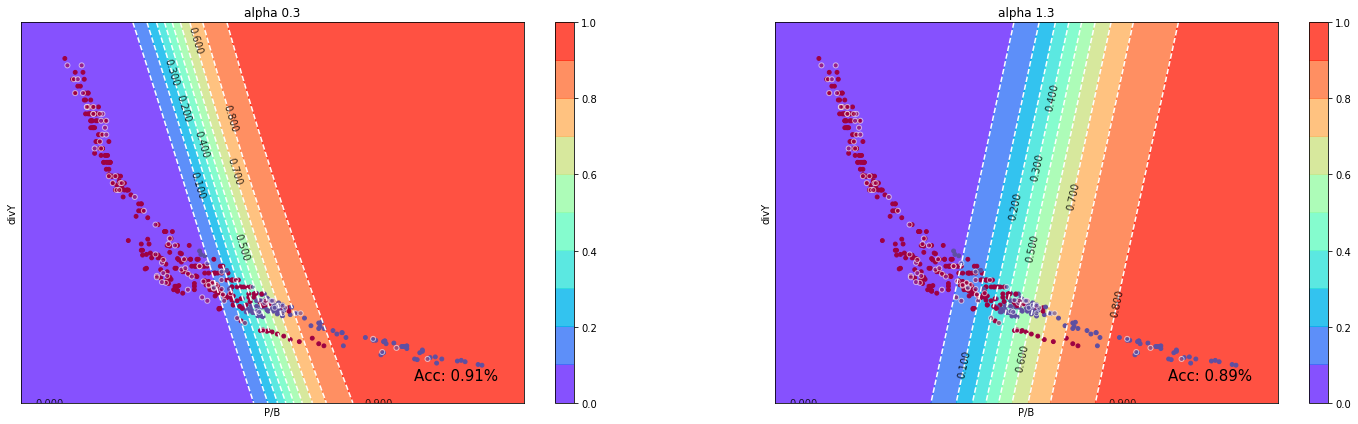

In [71]:
# Create a new figure with 30-inch width, 7-inch height
figure = plt.figure(figsize=(20, 7))  

# 设置横纵左边的长度及分段，根据数据长度而定
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# meshgrid函数就是用两个坐标轴上的点在平面上画网格(当然这里传入的参数是两个的时候)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),    # h = .02  step size in the mesh 网格中的步长
                         np.arange(y_min, y_max, h))


i = 1
# Iterate over classifiers
for name, clf in zip(names, classifiers):  # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    ax = plt.subplot(1, 2, i)               # Add a subplot to the current figure 
    clf.fit(X_train, y_train)               # Train the model with automatically 10-fold cross validation which has been specidies in Classifiers
    score = clf.score(X_test, y_test)       # Evaluate the model by calculating the test accuracy
    
    print("Test accuracy: %.2f%%" % (score*100))
    

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predict_proba 是（软）分类器的一种方法，用于输出实例在每个类中的概率。

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cm = plt.cm.rainbow                # 设置彩色色谱
    contour = ax.contourf(xx, yy, Z, 10, cmap=cm, alpha=.8)    # contourf(X,Y,Z) 指定 Z 中各值的 x 和 y 坐标，10 means 10 regions
    ax.contour(contour, linestyles = 'dashed', colors='white') # Add line contours on the graph
    plt.clabel(contour, inline=True, fontsize=10, colors='k')    # Add labels to line contours in our ContourSet object
    figure.colorbar(contour, ax=ax)
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=15)
    
    # Plot the testing points with whilte edgecolors
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, alpha=0.6, edgecolors='white', s=25)

    # Set the limits
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('Acc: %.2f%%' % score*100).lstrip('0'), size=15, horizontalalignment='right')
    plt.xlabel('P/B')
    plt.ylabel('divY')
    # plt.title('P2:DNN, Logistic, Probability Plot')
    i += 1

figure.subplots_adjust(left=.02, right=.98)

# Display the plot
plt.show()